# BrainMelody - A moving window seizure classifier powered by Neural Nets 
## Pipeline for Seizure Classification
### Place the EDF file in the 'EDF' folder, name it as: "evaluate.edf"
### Place the medical report in the 'Report' folder, name it as: "report.txt"
### Place the tse_bi file in 'Report' folder, name it as: "tse.tse_bi"
### Run predict() function

In [232]:
import pandas as pd
import numpy as np
import keras
from keras.models import load_model
import pyedflib
import string
import nltk
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Input
from keras.callbacks import EarlyStopping
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import string
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [33]:
# Function to convert edf to csv files and store them in the given folder with the index name
def edf_to_csv(link):
    #Loading the edf file
    edf = pyedflib.EdfReader(link)
    #Reading data from the file into a numpy array
    n = edf.signals_in_file
    signal_labels = edf.getSignalLabels()
    sigbufs = np.zeros((n, edf.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = edf.readSignal(i)
    #Converting the numpy array to Dataframe
    df = pd.DataFrame(sigbufs)
    df = df.iloc[0:32,:]
    #Storing the dataframe to csv
    df.to_csv(r"E:\EEG Analysis\CLASSIFIER\scrape\reformatted_main.csv", header=None, index=False)
    #Closing the file
    edf._close()
    del(edf)
    
def break_and_create():
    data = pd.read_csv(r"E:\EEG Analysis\CLASSIFIER\scrape\reformatted_main.csv", header=None)
    #Number of observations in the data file
    shape = int(data.shape[1])
    #Number of divisions to be made
    div = 0
    if shape%1000 == 0:
        div = int(shape/1000)
    else:
        div = int(shape/1000)+1
    #Breaking each file and saving to a a new folder
    start = 0
    end = 1000
    count = 0
    for i in range(div):
        if end <= shape:
            new_data = data.iloc[:,start:end]
            save_location = "E:/EEG Analysis/CLASSIFIER/scrape/"+str(count)+".csv"
            new_data.to_csv(save_location)
            start = start+1000
            end = end+1000
            count = count+1
        else:
            new_data = data.iloc[:,start:]
            new_data = new_data.values
            new_data = pad_sequences(new_data, padding='post', maxlen=1000)
            save_location = "E:/EEG Analysis/CLASSIFIER/scrape/"+str(count)+".csv"
            new = pd.DataFrame(new_data)
            new.to_csv(save_location)
            count = count+1
    return count

In [228]:
#Function to plot the probabilities of seizure
def plot_window(probs, time):
    arr = []
    for i in probs:
        arr.append(probs*1000)
    plt.figure(figsize=(10,10))
    plt.plot(arr, 'o', color = 'blue')
    plt.plot([0, time], [50, 50], 'k-', lw=1, color = 'green')
    plt.axis([0, time, 0, 100])
    plt.title("Seizure Probabilities for each second")
    plt.xlabel('Time')
    plt.ylabel('Probability in %')
    plt.show()
       
def iterate_second_windows(time, model):
    folder_location = "E:/EEG Analysis/CLASSIFIER/scrape/"
    file_count = time
    probs = []
    print("Processing EDF file. . .")
    pbar = tqdm_notebook(total=time)
    for i in range(time):
        data = pd.read_csv(folder_location+str(i)+".csv", header=None)
        data = data.iloc[1:,1:]
        data = data.values
        data = data.reshape((1, 32, 1000))
        res = model.predict(data)
        probs.append(res[0][0])
        pbar.update(1)
    pbar.close()
    return probs

In [229]:
def process_text(report_location):
    model = load_model('E:/EEG Analysis/CLASSIFIER/text_model.h5')
    file = open(report_location, encoding='utf-8') 
    text = file.read() 
    print("The report is: ", text)
    text = text.lower()
    exclude = set(string.punctuation)
    text = ''.join(ch for ch in text if ch not in exclude)
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    new_txt = []
    for word in words:
        new_txt.append(stemmer.stem(word))
    text = ' '.join(new_txt)
    data = pd.read_csv(r"E:\EEG DATA\train_ordered\02_tcp_le\Text_data\text_meta.csv")
    vectorizer = TfidfVectorizer(max_features=3561, max_df=0.9)
    vectorizer.fit(data['report'])
    vector = vectorizer.transform([text])
    result = model.predict_proba(vector)
    result = result[0]*100
    print(str(result),"% chances of Seizure estimated.")
    return result
    
def process_edf(edf_location):
    model = load_model('E:/EEG Analysis/CLASSIFIER/edf_model.h5')
    scrape_folder = "E:/EEG Analysis/CLASSIFIER/scrape"
    edf_to_csv(edf_location)
    time = break_and_create()
    print(str(time), "seconds of data recorded.")
    probs = []
    probs = iterate_second_windows(time, model)
    plot_window(probs, time)

In [234]:
def clear_cache():
    dir = "E:/EEG Analysis/CLASSIFIER/scrape"
    filelist = [ f for f in os.listdir(dir) ]
    for f in filelist:
        os.remove(os.path.join(dir, f))

def predict():
    edf_location = r"E:/EEG Analysis/CLASSIFIER/EDF/evaluate.edf"
    report_location = r"E:/EEG Analysis/CLASSIFIER/Report/report.txt"
    text_eval = process_text(report_location)
    process_edf(edf_location)
    print("Finished!")
    clear_cache()
    print("Cache in the scrape folder has been cleared.")

# Run the function below 

84 seconds of data recorded.
Processing EDF file. . .


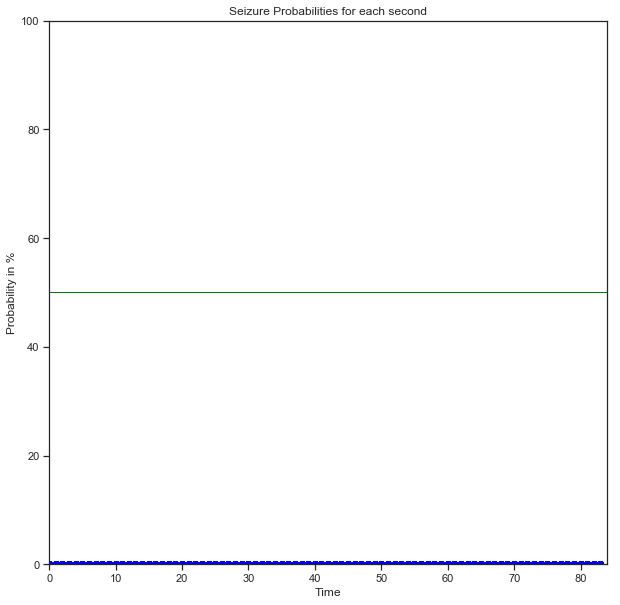

Finished!
Cache in the scrape folder has been cleared.


In [237]:
predict()